# World Wide Products Inc.
Data source : https://www.kaggle.com/felixzhao/productdemandforecasting#Historical%20Product%20Demand.csv


In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [330]:
from fbprophet import Prophet

### Load data

Convert 'Data' into date type while input.

In [331]:
df = pd.read_csv("../data/Historical Product Demand.csv",parse_dates=['Date'], infer_datetime_format=True)

C:\Users\Christine\Anaconda3\lib\site-packages\dateutil\parser\__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


# Feature explore

### Check null data and drop

In [332]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [333]:
df.dropna(inplace=True)

In [334]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


### Convert Order_demand into numeric type

In [335]:
df['Order_Demand'] = df['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'])

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1037336 non-null object
Warehouse           1037336 non-null object
Product_Category    1037336 non-null object
Date                1037336 non-null datetime64[ns]
Order_Demand        1037336 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 47.5+ MB


There are 33 product categories and 2160 products.

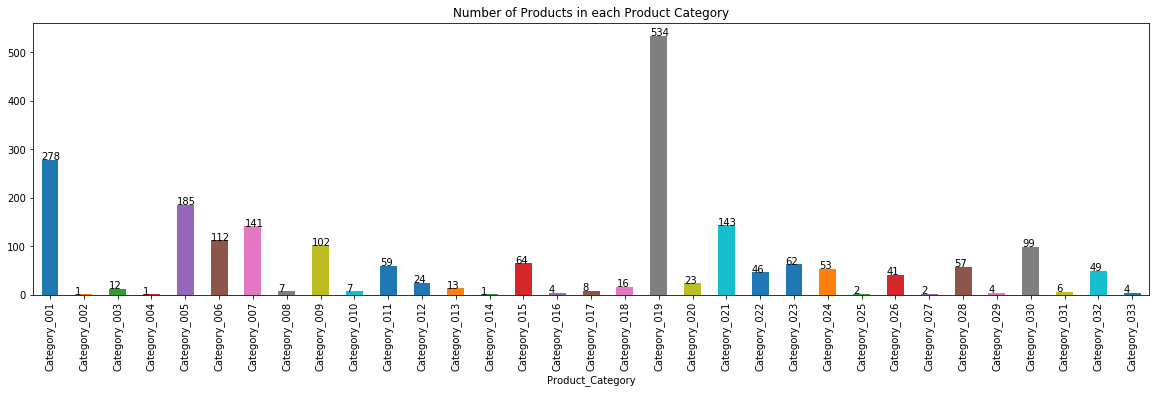

In [337]:
ax = df.groupby('Product_Category')['Product_Code'].nunique().plot(kind='bar',
                                    figsize=(20,5),
                                    title="Number of Products in each Product Category")
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(i.get_height()))

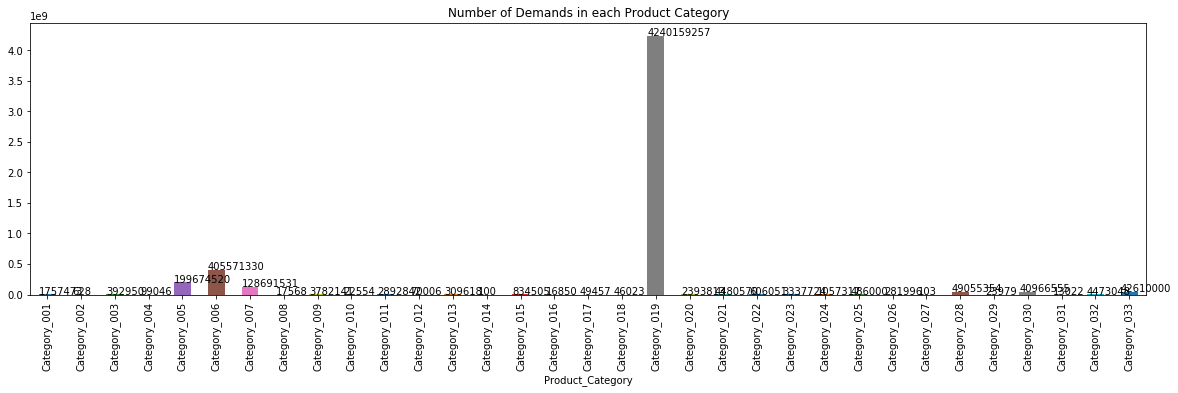

In [338]:
ax = df.groupby('Product_Category')['Order_Demand'].sum().plot(kind='bar',
                                    figsize=(20,5),
                                    title="Number of Demands in each Product Category")
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(i.get_height()))

As the above figs showed,category 019 is the most frequent. Now we will select products in Category 19 to do some experiment.

In [339]:
product_num = df[df['Product_Category']== 'Category_019'].groupby(['Product_Code']).size().reset_index(name="rows")
product_num.sort_values(['rows'],ascending=False).head(10)

,Product_Code,rows
263,Product_1359,16936
199,Product_1295,10575
279,Product_1378,9770
190,Product_1286,8888
283,Product_1382,8619
354,Product_1453,8503
198,Product_1294,8384
278,Product_1377,7872
191,Product_1287,7829
179,Product_1274,7048


### Look into a specific product

In [340]:
Product_1 = df[df["Product_Code"]=="Product_1295"]
Product_1.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
5787,Product_1295,Whse_J,Category_019,2012-01-23,50000
5788,Product_1295,Whse_J,Category_019,2012-02-08,50000
5789,Product_1295,Whse_J,Category_019,2012-03-08,50000
5790,Product_1295,Whse_J,Category_019,2012-03-26,50000
5791,Product_1295,Whse_J,Category_019,2012-04-26,50000


In [341]:
Product_1 = Product_1.groupby('Date')['Order_Demand'].sum().reset_index()
Product_1.head()

,Date,Order_Demand
0,2012-01-05,78700
1,2012-01-06,102100
2,2012-01-10,134000
3,2012-01-11,37600
4,2012-01-12,32100


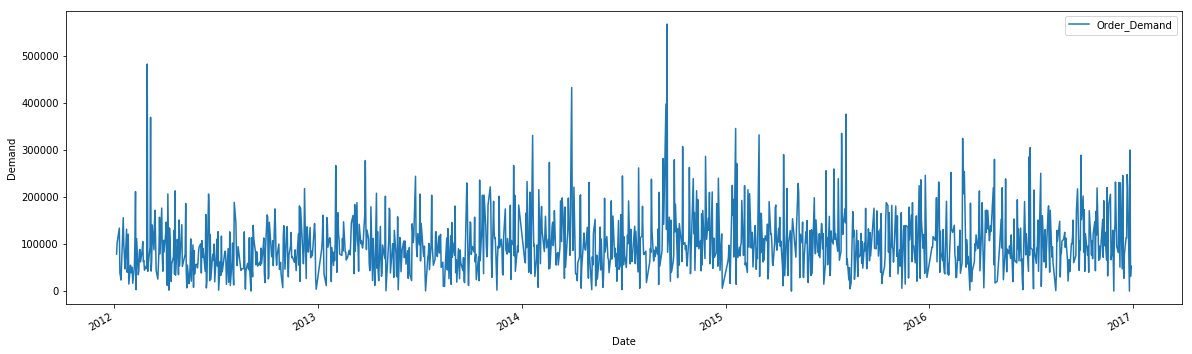

In [342]:
Product_1.pivot_table('Order_Demand', index='Date').plot(figsize=(20,6))
plt.ylabel('Demand');

### The demands on months
#### We need index data with time

In [343]:
Product_1_sample = Product_1.set_index('Date')
Product_1_sample.index

DatetimeIndex(['2012-01-05', '2012-01-06', '2012-01-10', '2012-01-11',
               '2012-01-12', '2012-01-13', '2012-01-16', '2012-01-17',
               '2012-01-18', '2012-01-19',
               ...
               '2016-12-15', '2016-12-16', '2016-12-19', '2016-12-20',
               '2016-12-21', '2016-12-22', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28'],
              dtype='datetime64[ns]', name='Date', length=1217, freq=None)

Check the date range

In [344]:
Product_1_sample.index.min(), Product_1_sample.index.max()

(Timestamp('2012-01-05 00:00:00'), Timestamp('2016-12-28 00:00:00'))

In [345]:
Product_1_sample = Product_1_sample["Order_Demand"].resample('MS').sum()
Product_1_sample.head()

Date
2012-01-01    1360800
2012-02-01    1863200
2012-03-01    2190800
2012-04-01    1817400
2012-05-01    1330700
Freq: MS, Name: Order_Demand, dtype: int64

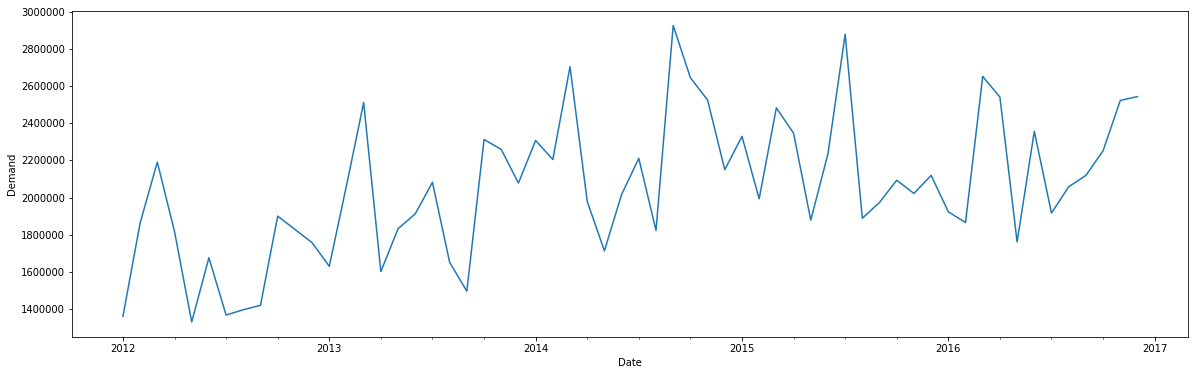

In [346]:
Product_1_sample.plot(figsize=(20,6))
plt.ylabel('Demand');

The products of the same category

In [347]:
Product_2 = df[df["Product_Code"]=="Product_1359"].groupby('Date')['Order_Demand'].sum().reset_index()
Product_2_sample = Product_2.set_index('Date')

In [348]:
Product_2_sample = Product_2_sample["Order_Demand"].resample('MS').sum()

In [349]:
Product_2_sample.index.min(), Product_2_sample.index.max()

(Timestamp('2012-01-01 00:00:00', freq='MS'),
 Timestamp('2017-01-01 00:00:00', freq='MS'))

We drop the data in 2017 as the data is imcomplete for 2017

In [350]:
Product_2_sample = Product_2_sample.drop(pd.to_datetime('2017-01-01'))

In [351]:
product1_sample = pd.DataFrame({'Date':Product_1_sample.index, 'Order_Demand':Product_1_sample.values})
product2_sample = pd.DataFrame({'Date': Product_2_sample.index, 'Order_Demand': Product_2_sample.values})
MergeProduct = product1_sample.merge(product2_sample, how='inner', on='Date')
MergeProduct.head()

,Date,Order_Demand_x,Order_Demand_y
0,2012-01-01,1360800,8911000
1,2012-02-01,1863200,8131000
2,2012-03-01,2190800,7775000
3,2012-04-01,1817400,8960000
4,2012-05-01,1330700,8475000


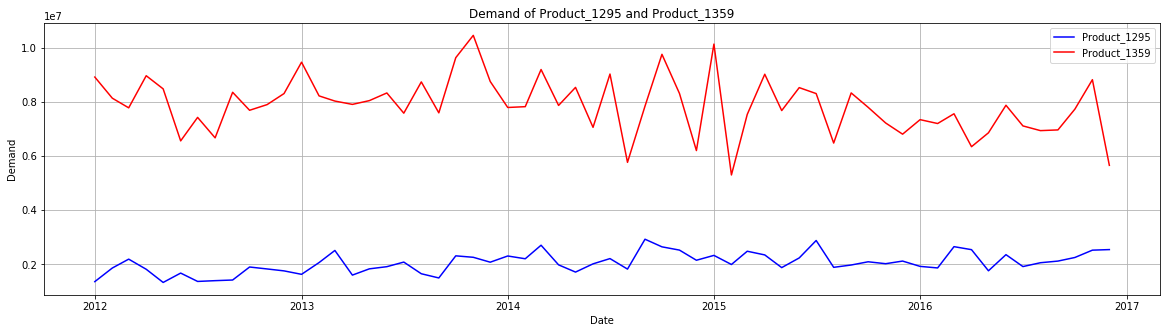

In [352]:
plt.figure(figsize=(20, 5))
plt.plot(MergeProduct['Date'], MergeProduct['Order_Demand_x'], 'b-', label = 'Product_1295')
plt.plot(MergeProduct['Date'], MergeProduct['Order_Demand_y'], 'r-', label = 'Product_1359')
plt.xlabel('Date'); plt.ylabel('Demand'); plt.title('Demand of Product_1295 and Product_1359')
plt.grid()
plt.legend();

# Forecast
Forecasting with Facebook Prophet. Link:https://github.com/facebook/prophet
Need to install fbprophet

### Product 1

In [353]:
Product_1.head()

,Date,Order_Demand
0,2012-01-05,78700
1,2012-01-06,102100
2,2012-01-10,134000
3,2012-01-11,37600
4,2012-01-12,32100


In [354]:
Product_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 2 columns):
Date            1217 non-null datetime64[ns]
Order_Demand    1217 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.1 KB


In [355]:
Product_1.columns = ['ds', 'y']
Product_1.head(3)

,ds,y
0,2012-01-05,78700
1,2012-01-06,102100
2,2012-01-10,134000


In [356]:
product1_model = Prophet(interval_width=0.95, daily_seasonality=True)
product1_model.fit(Product_1)

In [357]:
product1_future = product1_model.make_future_dataframe(periods=36, freq='MS')
product1_forecast = product1_model.predict(product1_future)

In [358]:
product1_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1248,2019-08-01,106842.748617,-10937.533688,231853.065998
1249,2019-09-01,15354.092404,-113097.900045,142042.742131
1250,2019-10-01,128975.206960,10373.385785,248625.565954
1251,2019-11-01,107753.130002,-13024.516549,229638.255359
1252,2019-12-01,46961.598801,-71818.326866,163684.225902


<Figure size 1296x432 with 0 Axes>

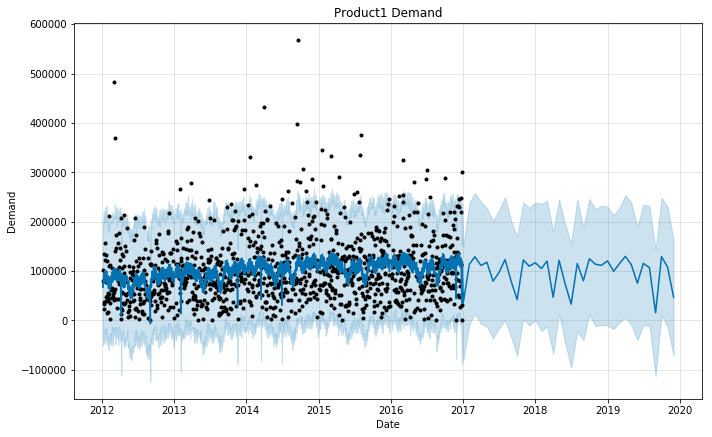

In [359]:
plt.figure(figsize=(18, 6))
product1_model.plot(product1_forecast, xlabel = 'Date', ylabel = 'Demand')
plt.title('Product1 Demand');

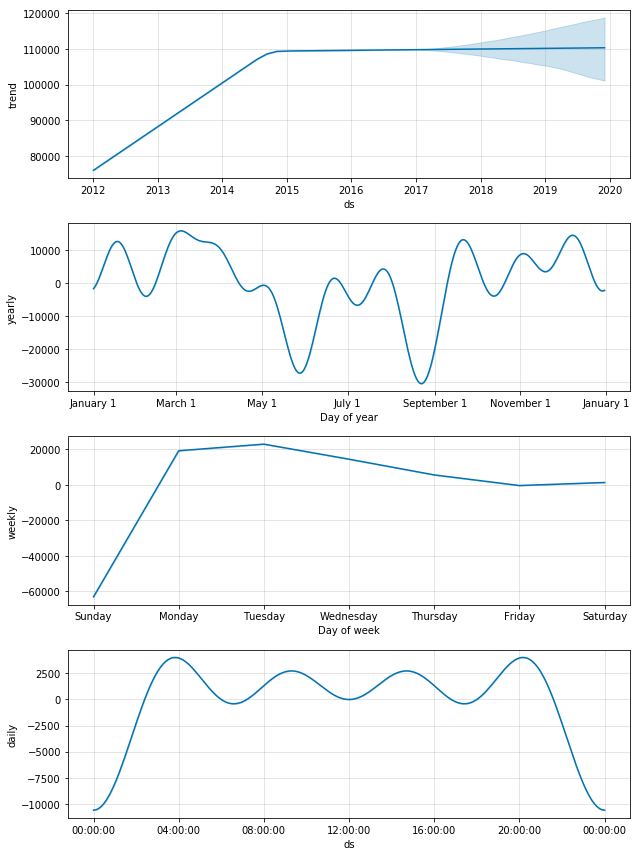

In [360]:
product1_model.plot_components(product1_forecast);

 ## Using monthly data

We can see from the result that, when we run the forecasting algorithm, it is hard to tell the trend with original data. While resample the data with monthly frequncy can give better result.

In [361]:
Product_1_sample.head()

Date
2012-01-01    1360800
2012-02-01    1863200
2012-03-01    2190800
2012-04-01    1817400
2012-05-01    1330700
Freq: MS, Name: Order_Demand, dtype: int64

In [364]:
Product_1_month = pd.DataFrame({'ds':Product_1_sample.index, 'y':Product_1_sample.values})

In [366]:
Product_1_month.head()

,ds,y
0,2012-01-01,1360800
1,2012-02-01,1863200
2,2012-03-01,2190800
3,2012-04-01,1817400
4,2012-05-01,1330700


In [367]:
product1_month_model = Prophet(interval_width=0.95, weekly_seasonality=True)
product1_month_model.fit(Product_1_month)
product1_month_future = product1_month_model.make_future_dataframe(periods=36, freq='MS')
product1_month_forecast = product1_month_model.predict(product1_month_future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [368]:
product1_month_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2019-08-01,1.959571e+06,1.579156e+06,2.297297e+06
92,2019-09-01,2.206749e+06,1.824871e+06,2.554834e+06
93,2019-10-01,2.324660e+06,1.951355e+06,2.734568e+06
94,2019-11-01,2.555741e+06,2.186840e+06,2.925126e+06
95,2019-12-01,2.228377e+06,1.847016e+06,2.605560e+06


<Figure size 1296x432 with 0 Axes>

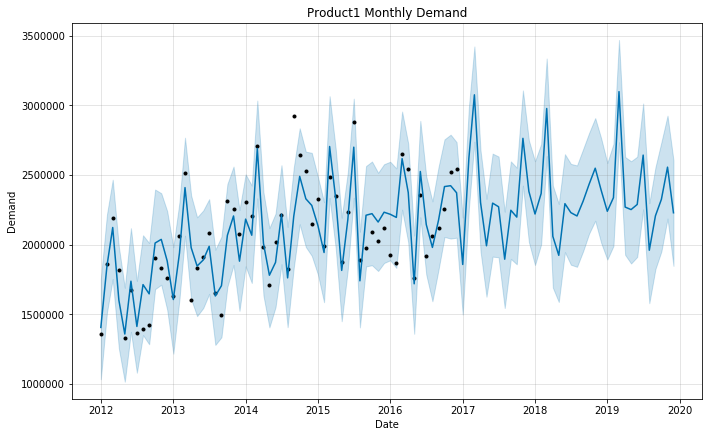

In [371]:
plt.figure(figsize=(18, 6))
product1_month_model.plot(product1_month_forecast, xlabel = 'Date', ylabel = 'Demand')
plt.title('Product1 Monthly Demand');

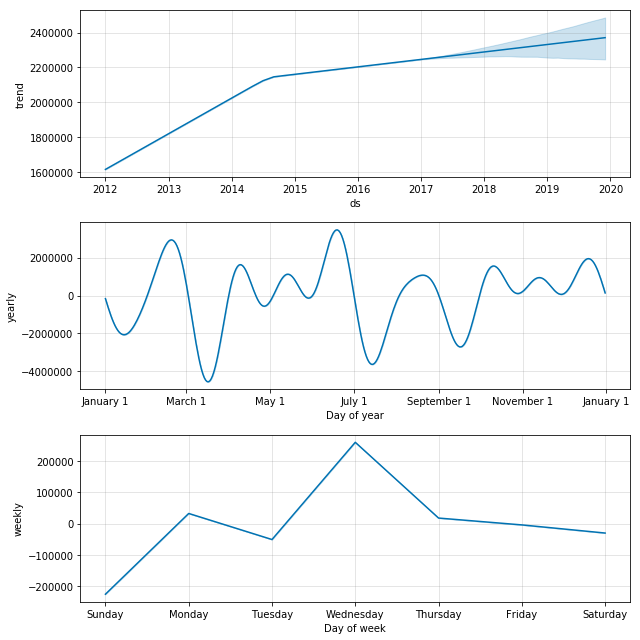

In [373]:
product1_month_model.plot_components(product1_month_forecast);

### Product 2 Monthly

In [374]:
Product_2_month = pd.DataFrame({'ds':Product_2_sample.index, 'y':Product_2_sample.values})

In [377]:
product2_model = Prophet(interval_width=0.95,weekly_seasonality=True)
product2_model.fit(Product_2_month)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [379]:
product2_future = product2_model.make_future_dataframe(periods=36, freq='MS')
product2_forecast = product2_model.predict(product2_future)

In [380]:
product2_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2019-08-01,5.727922e+06,4.288456e+06,7.171680e+06
92,2019-09-01,6.210392e+06,4.724851e+06,7.772564e+06
93,2019-10-01,7.683116e+06,6.109317e+06,9.241520e+06
94,2019-11-01,7.005735e+06,5.551182e+06,8.608749e+06
95,2019-12-01,5.492661e+06,4.064837e+06,6.918079e+06


<Figure size 1296x432 with 0 Axes>

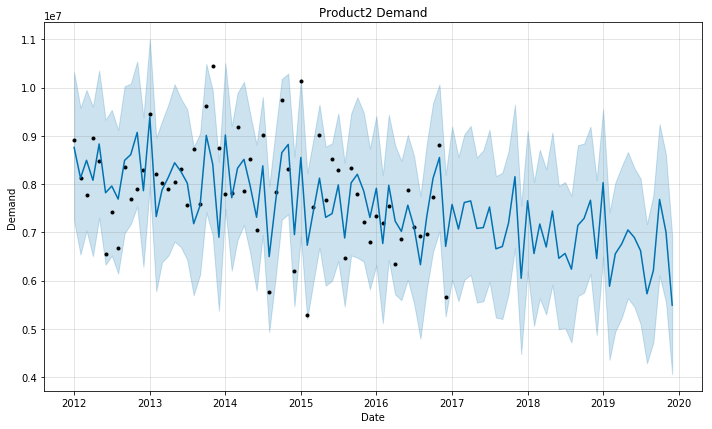

In [381]:
plt.figure(figsize=(18, 6))
product2_model.plot(product2_forecast, xlabel = 'Date', ylabel = 'Demand')
plt.title('Product2 Demand');

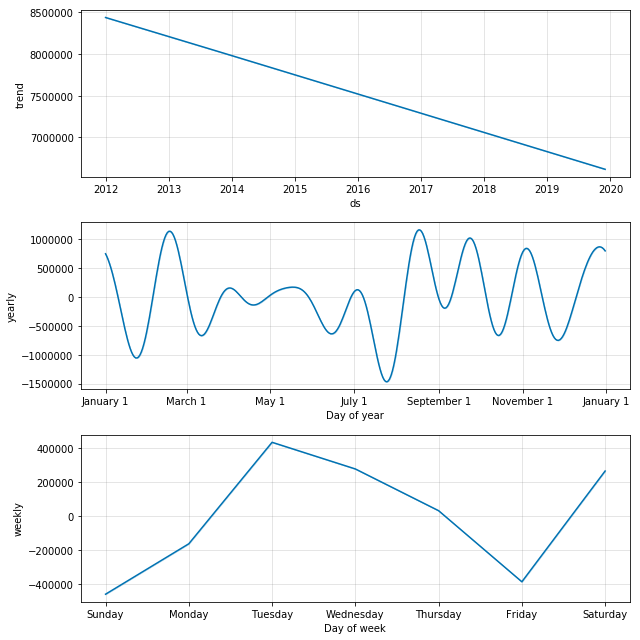

In [382]:
product2_model.plot_components(product2_forecast);

Prediction: The demands of Product 1 is incresing while the demands of the product 2 is not that promising.

### Divide the date column into year, month and day

In [ ]:
# Convert the series' types
# df['year'] = df['Date'].dt.year.astype(int)
# df['month'] = df['Date'].dt.month.astype(int)
# df['day'] = df['Date'].dt.day.astype(int)